In [6]:
from IPython.display import Image
import pandas as pd
import numpy as np

### Q1 (15 points) 

#### This question is to be solved by hand.

Given the following learned Bayesian network structure explaining the relationships between variables in container shipping data:

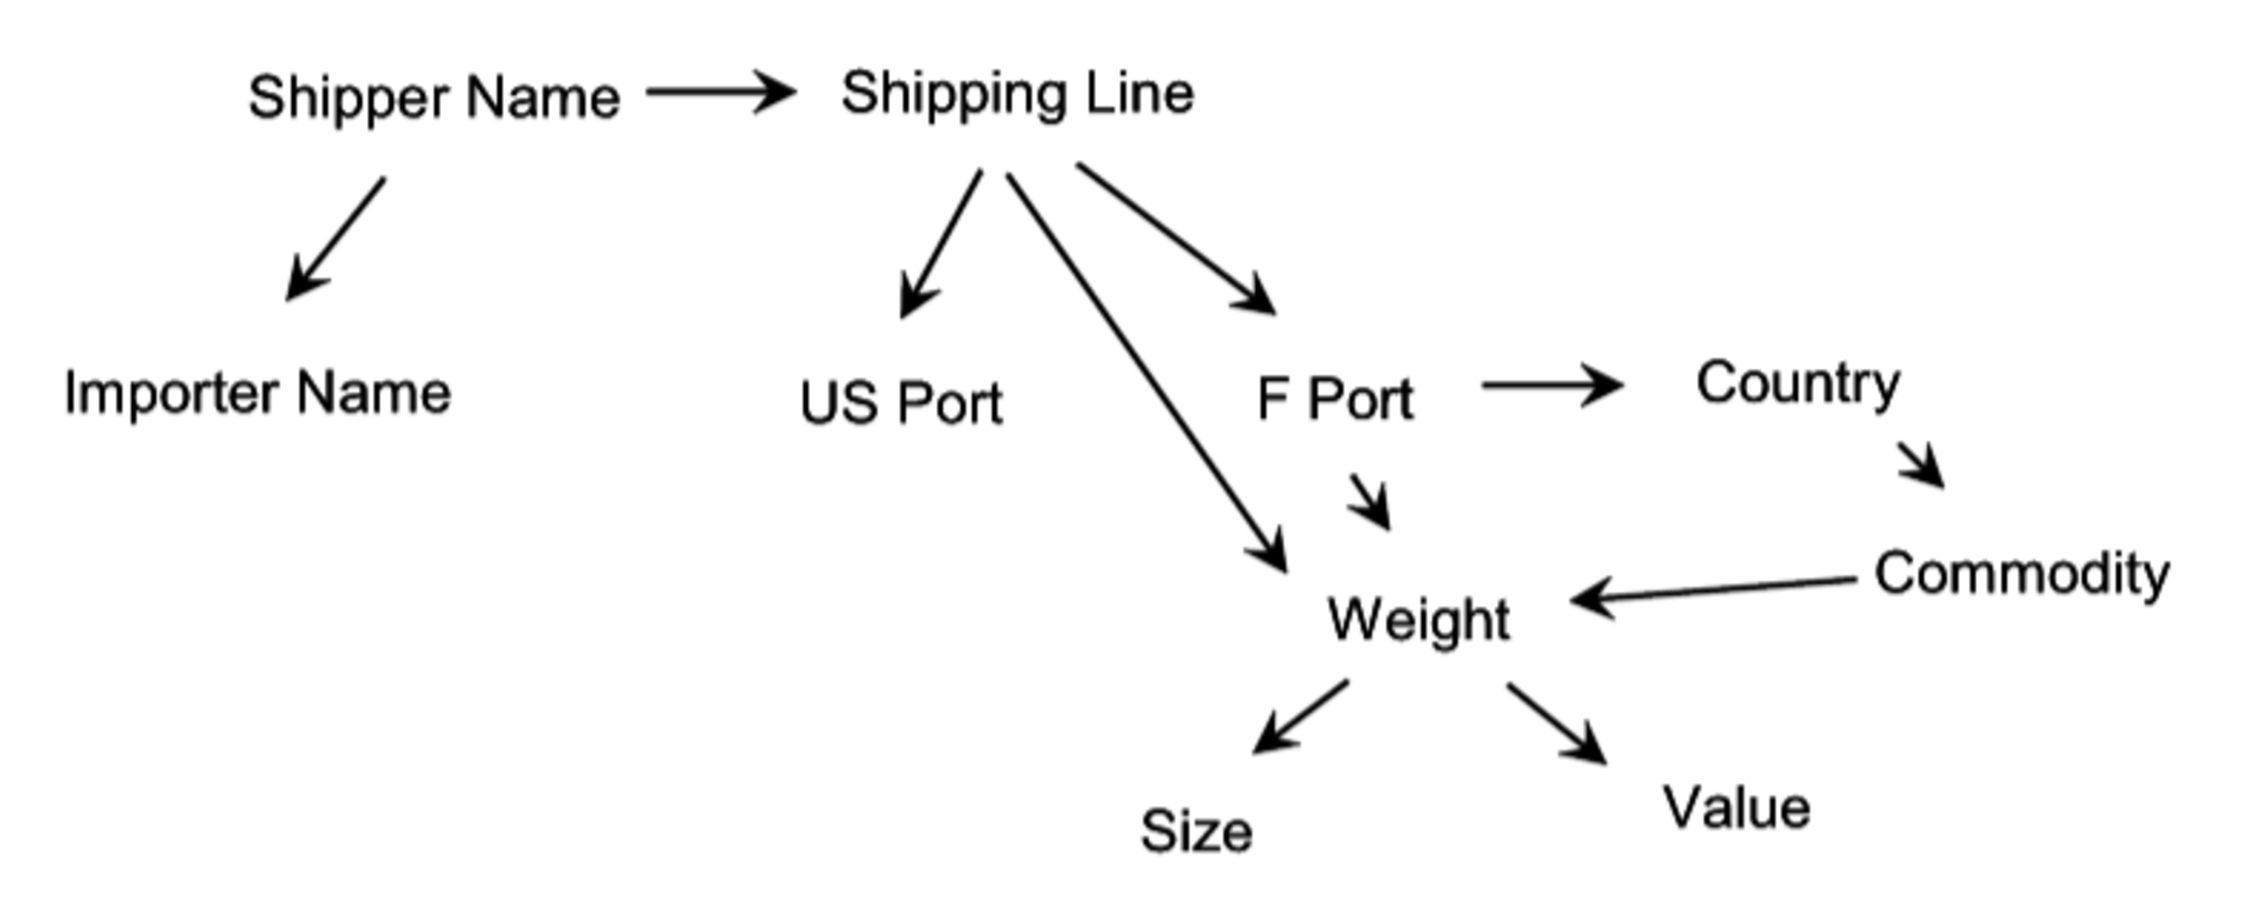

In [7]:
Image('HW3Q1.png')

1) Which of the following conditional independence relationships hold? Choose “Independent” or “Dependent” for each (6 points):

CI (Shipper Name, Value | F Port)? **Dependent**

CI (Shipper Name, Value | Shipping Line)? **Independent**

CI (Foreign Port, Commodity | Country)? **Independent**

CI (Foreign Port, Commodity | County, Weight)? **Dependent**

2) Now consider a smaller dataset with only four discrete attributes (Shipping Line, US Port, Foreign Port, Weight), and the following conditional probability distributions:

Shipping Line: CSCO (70%), ASCO (30%)

Foreign Port | Shipping Line = CSCO: Yokohama (40%), Vancouver (60%)

Foreign Port | Shipping Line = ASCO: Vancouver (100%)

US Port | Shipping Line = ASCO: Seattle (100%)

US Port | Shipping Line = CSCO: Seattle (80%), Los Angeles (20%)

Weight | Shipping Line = CSCO, Foreign Port = Vancouver: Light (30%), Medium (50%), Heavy (20%)

Weight | Shipping Line = CSCO, Foreign Port = Yokohama: Light (10%), Medium (30%), Heavy (60%)

Weight | Shipping Line = ASCO, Foreign Port = Vancouver: Light (15%), Medium (70%), Heavy (15%)

Which of the following packages is most anomalous?

a) A heavy package shipped from Vancouver to Seattle by ASCO

Weight = Heavy, FPort = Vancouver, USPort = Seattle, ShipLine = ASCO

P(ASCO) = 0.3

P(SEA | ASCO) = 1.0

P(VAN | ASCO) = 1.0

P(Heavy | VAN,ASCO) = 0.15

====> 0.3 * 1.0 * 1.0 * 0.15 = **4.50%** 

b) A heavy package shipped from Vancouver to Seattle by CSCO

Weight = Heavy, FPort = Vancouver, USPort = Seattle, ShipLine = CSCO

P(CSCO) = 0.7

P(SEA | CSCO) = 0.8

P(VAN | CSCO) = 0.60

P(Heavy | VAN,CSCO) = 0.20

=====> 0.7 * 0.8 * 0.6 * 0.2 = **6.72%**

**c) A heavy package shipped from Yokohama to Los Angeles by CSCO**

Weight = Heavy, FPort = Yokohama, USPort = LA, ShipLine = CSCO

P(CSCO) = 0.7

P(LA | CSCO) = 0.2

P(YOKO | CSCO) = 0.40

P(Heavy | YOKO,CSCO) = 0.60

====> 0.7 * 0.2 * 0.4 * 0.6 = **3.36%**


To answer this question, compute the likelihood of each package given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9 points)

print("**The most anomalous (least likely) package is package (C) because it has the least probability of happening**")

### Q2. Bayesian Network Learning (35 points)

In this question, we use dataset: "HW3Q2.csv" for Bayesian Network Learning.

In [8]:
from sklearn.model_selection import train_test_split
data2=pd.read_csv("HW3Q2.csv")
train,test=train_test_split(data2,random_state=9,test_size=0.4)
data2.head()

,A,B,C,D,E,F
0,1,0,0,0,1,1
1,0,0,0,1,0,1
2,1,1,0,1,1,1
3,1,0,0,1,1,1
4,2,0,1,0,1,1


a) Use the training data to select the best structure you want to use for Bayesian Network Learning. Please use Hill Climbing with BIC score metric. (10 points)

b) Use the Bayesian Estimator to estimate the CPDs for your model and visualize the network with CPDs. (15 points)

c) Use the model to predict "A" for the testing dataset. Report the out-of-sample prediction accuracy. (10 points)   

In [9]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BayesianEstimator, K2Score, BicScore, BDeuScore
from pgmpy.models import BayesianModel

hc = HillClimbSearch(train, scoring_method=BicScore(train))
best_model = BayesianModel(hc.estimate().edges()) # convert DAG to BayesianModel
print(best_model.edges())

C:\Users\erikl\Anaconda2\envs\AppliedDataScience\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[('B', 'A'), ('D', 'A'), ('E', 'A')]


In [10]:
# CPD == conditional probability distribution
best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')

In [11]:
train_x = train[['B','D','E']]
predicted_train = best_model.predict(train_x)
print("In sample:",(train.loc[:,'A'].reset_index(drop=True)==predicted_train['A']).mean())

test_x = test[['B','D','E']]
predicted_test = best_model.predict(test_x)
print("Out of sample:",(test.loc[:,'A'].reset_index(drop=True)==predicted_test['A']).mean())

100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1603.71it/s]

In sample: 0.5766666666666667
Out of sample: 0.5645


### Q3. Clustering: Spatial and Temporal Distributions of Chicago Crimes (50 points)

In this question you will use k-means and Gaussian mixture clustering in sklearn and hierarchical clustering in scipy to answer the question, “Do different types of crime display different trends over space and time?”  The dataset “HW3Q3_1.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

- The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

- The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

- The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

- Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

- Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

- Category = “P2” corresponds to Part 2 (less serious) crimes.

To answer parts a through f, you should cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes.

a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

c) Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)  

d) Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (5 pts)

e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)


In [12]:
data3=pd.read_csv("HW3Q3_1.csv")
data3.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.019830,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.037037,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.035377,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.028000,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.029412,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000


In [13]:
data4=pd.read_csv("HW3Q3_2.csv")
data4.head()

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
0,1,Rogers Park,1164399.219,1947666.815,7.7,23.6,8.7,18.2,27.5,23939,11.870556,3420
1,2,West Ridge,1158307.200,1943243.722,7.8,17.2,8.8,20.8,38.5,23040,9.870385,3068
2,3,Uptown,1168228.082,1930980.022,3.8,24.0,8.9,11.8,22.2,35787,8.672137,3330
3,4,Lincoln Square,1159618.804,1933105.743,3.4,10.9,8.2,13.4,25.5,37524,8.600422,1859
4,5,North Center,1161104.228,1924056.010,0.3,7.5,5.2,4.5,26.2,57123,10.100636,1280


In [51]:
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster  # for hierarchical clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import fcluster

import matplotlib.pyplot as plt

def find_best_cluster(max_clusters, input_data, labels_func):
    best_cluster = 0
    best_avg = -1
    best_labels = []
    for n_clusters in range(2,max_clusters+1):
        cluster_labels = labels_func(input_data, n_clusters)
        silhouette_avg = silhouette_score(input_data, cluster_labels)
        if silhouette_avg > best_avg:
            best_avg = silhouette_avg
            best_cluster = n_clusters
            best_labels = cluster_labels
    return {'cluster_num': best_cluster, 'labels': best_labels, 'score': best_avg}

def get_kmeans_labels(input_data, n_clusters):
    km = KMeans(random_state = 1993, n_clusters = n_clusters)
    km.fit(input_data)
    res = km.predict(input_data)
    return res

def get_gaussian_labels(input_data, n_clusters):
    gmm = GaussianMixture(n_components = n_clusters, random_state = 1993)
    gmm.fit(input_data)
    res = gmm.predict(input_data)
    return res

def visualize_avgs(input_data, n_clusters, start_col, end_col, x_label=None):
    avgs = pd.DataFrame()
    plt.figure(figsize=(15,5))

    for cluster in range(0, n_clusters):
        temp = input_data[input_data['cluster'] == cluster].loc[:, start_col:end_col].mean()
        
        if x_label:
            plt.plot(np.arange(1, len(temp)+1), temp.values, label=cluster)
            plt.xticks(np.arange(1, len(temp)+1, 2.0))
            plt.xlabel(x_label)
        else:
            plt.plot(temp.index, temp.values, label=cluster)
            
        temp['cluster'] = cluster
        avgs = avgs.append(temp, ignore_index=True)
    plt.legend(range(0, n_clusters))
    plt.show()   
    return avgs

def top_5(input_data, n_clusters, start_col, end_col):
    avgs = pd.DataFrame()

    for cluster in range(0, n_clusters):
        temp = input_data[input_data['cluster'] == cluster].loc[:, start_col:end_col].mean()     
        temp['cluster'] = cluster
        
        print(temp)
        
        avgs = avgs.append(temp, ignore_index=True)
 
    return avgs

def describe_labels(labels, score, title):
    print(title+" Clusters: {}, Score: {}".format(len(set(labels)), score))
    for cluster in np.unique(labels):
        print("Cluster {}, Size: {}".format(cluster, (labels == cluster).sum()))
    print()
        
def get_linkage_info(max_clusters, input_data, link_type):
    best_cluster = 0
    best_avg = -1
    best_labels = []
    Z = linkage(input_data, link_type)
    for n_clusters in range(2,max_clusters+1):
        cluster_labels = fcluster(Z, n_clusters, criterion = 'maxclust')    
        silhouette_avg = silhouette_score(input_data, cluster_labels)
        if silhouette_avg > best_avg:
            best_avg = silhouette_avg
            best_cluster = n_clusters
            best_labels = cluster_labels
    return {'cluster_num': best_cluster, 'labels': best_labels, 'score': best_avg}


a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster. (5 pts)



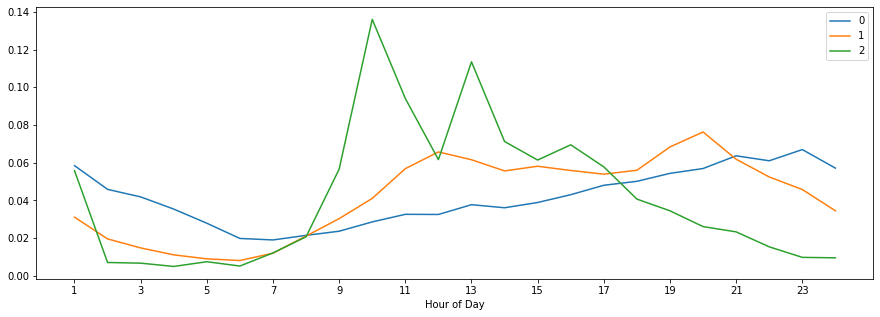

In [15]:
print("a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a "
      "line graph to visualize these values by cluster. (5 pts)\n")

labels3 = get_kmeans_labels(data3.loc[:, "hour_0":"hour_23"], 3)
data3['cluster'] = labels3
hourAvgs = visualize_avgs(data3, 3, "hour_0", "hour_23", x_label='Hour of Day')

In [16]:
print("b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).\n")
print("There seems to be 3 types of trends in these 3 clusters")
print("Cluster 0) Crime that rises steadily from 6 AM until midnight, and declines outside those hours")
print("Cluster 1) Steady Crime rise during daylight, stays high, and declines at night")
print("Cluster 2) Crime that rises quickly in the morning commute and wanes by end of the working day")

b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

There seems to be 3 types of trends in these 3 clusters
Cluster 0) Crime that rises steadily from 6 AM until midnight, and declines outside those hours
Cluster 1) Steady Crime rise during daylight, stays high, and declines at night
Cluster 2) Crime that rises quickly in the morning commute and wanes by end of the working day


In [18]:
print('c) Do you notice any consistent trends about which crime types are assigned to which cluster? Note that by'
      ' a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI'
      ' categories. (5 pts)\n')

print("Cluster 0 seems to have mostly violent crimes related to: BATTERY, ROBBERY, CRIMINAL DAMAGE, SEX OFFENSES")
print("Cluster 1 seems to have mostly crimes related to: NARCOTICS, & OTHER OFFENSES")
print("Cluster 2 seems to be the least violent of all with most crime types being DECEPTIVE PRACTICES ")

for cluster in range(0,3):
    print("Cluster {} crime_types:".format(cluster))
    temp = data3[data3['cluster'] == cluster]
    print(temp['crime_type'].unique())

c) Do you notice any consistent trends about which crime types are assigned to which cluster? Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)

Cluster 0 seems to have mostly violent crimes related to: BATTERY, ROBBERY, CRIMINAL DAMAGE, SEX OFFENSES
Cluster 1 seems to have mostly crimes related to: NARCOTICS, & OTHER OFFENSES
Cluster 2 seems to be the least violent of all with most crime types being DECEPTIVE PRACTICES 
Cluster 0 crime_types:
['ARSON: BY FIRE' 'ASSAULT: AGG PO HANDS NO/MIN INJURY'
 'ASSAULT: AGGRAVATED: HANDGUN' 'ASSAULT: AGGRAVATED: OTHER FIREARM'
 'ASSAULT: AGGRAVATED:KNIFE/CUTTING INSTR'
 'BATTERY: AGG PO HANDS NO/MIN INJURY'
 'BATTERY: AGG: HANDS/FIST/FEET SERIOUS INJURY'
 'BATTERY: AGGRAVATED DOMESTIC BATTERY: HANDS/FIST/FEET SERIOUS INJURY'
 'BATTERY: AGGRAVATED DOMESTIC BATTERY: KNIFE/CUTTING INST'
 'BATTERY: AGGRAVATED DOMESTIC BATTERY: OTHER DANG WEAPON'
 'BATTERY: AGGRAVATED: HA

d) Do the three clusters have different day-of-week trends? Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences. (5 pts)

Yes, there's different day-of-week trends:
Cluster 0 seems to be more active on the weekend
Cluster 1 seems to drop off somewhat during the weekend
Cluster 2 drops off significally during the weekend!


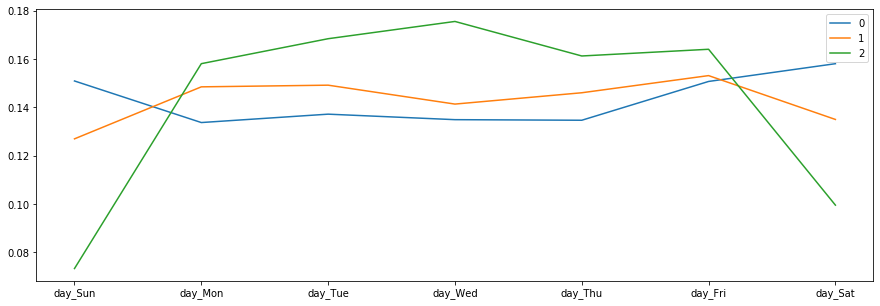

In [20]:
print("d) Do the three clusters have different day-of-week trends? Again, visualize the trends for each cluster by "
      "creating a line graph and discuss any notable differences. (5 pts)\n")

print("Yes, there's different day-of-week trends:")
print("Cluster 0 seems to be more active on the weekend")
print("Cluster 1 seems to drop off somewhat during the weekend")
print("Cluster 2 drops off significally during the weekend!")

dayAvgs = visualize_avgs(data3, 3, "day_Sun", "day_Sat")

e) Do the three clusters affect different types of communities/neighborhoods? To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster. You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.). You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

From looking at the top hot spots for crime in each cluster we see the following: 

* Cluster 0 and 1 mostly affect communities [25,29,23] which are all in the far West Side of Chicago, which are considerably poorer and less wealthy
* Cluster 2 mostly affects communities [8,32,28] which are either in Downtown or Near West of Downtown Chicago, which are richer with less people living in povert

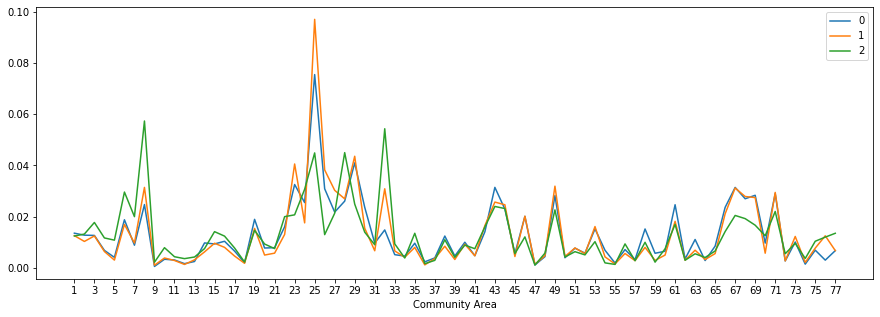

Top 3 Affected Communities:  {'29', '8', '23', '32', '28', '25'}


,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
7,8,Near North Side,1175512.220,1906089.147,1.9,12.9,7.0,2.5,22.6,88669,17.077160,9847
22,23,Humboldt park,1151216.159,1906926.141,14.8,33.9,17.3,35.4,38.0,13781,15.839488,7522
24,25,Austin,1140839.462,1903174.321,6.3,28.6,22.6,24.4,37.9,15957,14.188517,15719
27,28,Near West Side,1167030.371,1898359.955,3.8,20.6,10.7,9.6,22.2,44689,11.790159,8891
28,29,North Lawndale,1152306.328,1892568.863,7.4,43.1,21.2,27.6,42.7,12034,21.888178,8073
31,32,Loop,1176373.765,1899831.267,1.5,14.7,5.7,3.1,13.5,65526,24.629080,8471


In [39]:
print('e) Do the three clusters affect different types of communities/neighborhoods? To answer this question, you could'
      ' first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and'
      ' identify particular community areas with disproportionate amounts of a given cluster. You can then use the provided'
      ' file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty,'
      ' overcrowding, etc.). You may also wish to consult the Chicago Community Areas map at'
      ' https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)\n')

print("From looking at the top hot spots for crime in each cluster we see the following: \n\n"
"* Cluster 0 and 1 mostly affect communities [25,29,23] which are all in the far West Side of Chicago, which are considerably"
      " poorer and less wealthy\n"
"* Cluster 2 mostly affects communities [8,32,28] which are either in Downtown or Near West of Downtown Chicago, which are"
      " richer with less people living in poverty\n")

commAvgs = visualize_avgs(data3, 3, "community_area_1", "community_area_77", x_label="Community Area")

top3 = commAvgs.set_index('cluster').apply(lambda x: pd.Series(x.sort_values(ascending=False).iloc[:3].index, 
      index=['top1','top2','top3']), axis=1).reset_index()

communities = top3[['top1','top2','top3']].apply(lambda x: x.apply(lambda y: y.split("_")[2]), axis=1)
list_comms = communities.apply(pd.Series).stack().tolist()
print("Top 3 Affected Communities: ", set(list_comms))
data4[data4['Community Area Number'].isin(list_comms)]

In [40]:
print('f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between'
      ' P1V, P1P, and P2 crimes? (5 pts)\n')
print("As we can see there's no clear division betwee Category and Clusters\n"
    "Cluster 0 seems to contain almost save numbers of P1V and P2 crimes, violent and less violent crimes\n"
    "Cluster 1 seems to tend heavier towards P2 crimes, less violent crime\n"
    "Cluster 2 seems only contains P2 crimes\n"
    "So this clustering process doesn't mimic at all the FBI categories")

data3[['cluster', 'Category']].groupby(['cluster','Category']).size()

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

As we can see there's no clear division betwee Category and Clusters
Cluster 0 seems to contain almost save numbers of P1V and P2 crimes, violent and less violent crimes
Cluster 1 seems to tend heavier towards P2 crimes, less violent crime
Cluster 2 seems only contains P2 crimes
So this clustering process doesn't mimic at all the FBI categories


cluster  Category
0        P1P          6
         P1V         22
         P2          25
1        P1P          9
         P1V          2
         P2          43
2        P2          12
dtype: int64

In [41]:
print('g) For part g, you will use the same dataset to compare the clusters produced by several different methods.'
      ' But this time you should cluster using only the day-of-week (not hour-of-day) attributes (day_Sun..day_Sat).'
      ' Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up'
      ' hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with'
      ' "complete link" distance metric. In each case, you should choose the number of clusters using the silhouette'
      ' method (or another established method of your choice- please specify). For each clustering, report the number'
      ' of clusters formed and the number of elements in each cluster. You should also identify any notable similarities'
      ' or differences between the clusterings. (20 pts)')

g) For part g, you will use the same dataset to compare the clusters produced by several different methods. But this time you should cluster using only the day-of-week (not hour-of-day) attributes (day_Sun..day_Sat). Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric. In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify). For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)


In [42]:
kmean_cluster_info = find_best_cluster(10, data3.loc[:, "day_Sun":"day_Sat" ], get_kmeans_labels)
gauss_cluster_info = find_best_cluster(10, data3.loc[:, "day_Sun":"day_Sat" ], get_gaussian_labels)
sing_cluster_info = get_linkage_info(10, data3.loc[:, "day_Sun":"day_Sat" ], 'single')
comp_cluster_info = get_linkage_info(10, data3.loc[:, "day_Sun":"day_Sat" ], 'complete')

In [52]:
print("Looking at the results: \n"
      " KMeans resulted in a 3 very small clusters compared to the other 2\n"
      " Gaussian has a more even distribution of elements between its 4 clusters\n"
      " Both Single & Complete linkage severely underperformed by clustering basically all elements into one cluster\n")

describe_labels(kmean_cluster_info['labels'],kmean_cluster_info['score'], "KMeans")
describe_labels(gauss_cluster_info['labels'],gauss_cluster_info['score'], "Gaussian")
describe_labels(sing_cluster_info['labels'], sing_cluster_info['score'], "Single")
describe_labels(comp_cluster_info['labels'], comp_cluster_info['score'], "Complete")

Looking at the results: 
 KMeans resulted in a 3 very small clusters compared to the other 2
 Gaussian has a more even distribution of elements between its 4 clusters
 Both Single & Complete linkage severely underperformed by clustering basically all elements into one cluster

KMeans Clusters: 5, Score: 0.2423663882484861
Cluster 0, Size: 44
Cluster 1, Size: 58
Cluster 2, Size: 9
Cluster 3, Size: 6
Cluster 4, Size: 2

Gaussian Clusters: 4, Score: 0.2681165999507103
Cluster 0, Size: 6
Cluster 1, Size: 13
Cluster 2, Size: 13
Cluster 3, Size: 87

Single Clusters: 2, Score: 0.6377648080667613
Cluster 1, Size: 118
Cluster 2, Size: 1

Complete Clusters: 2, Score: 0.6100646113547021
Cluster 1, Size: 2
Cluster 2, Size: 117

